In [ ]:
# Code stipends taken from : ipython-books.github.io

In [1]:
pip install smopy

In [2]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# We load the data (a Shapefile dataset) with NetworkX.
#  This dataset contains detailed information about the primary roads in California.
#   NetworkX's read_shp() function returns a graph, where each node is a geographical 
#   position, and each edge contains information about the road linking the two nodes. 
#   The data comes from the United States Census Bureau website at 
#   http://www.census.gov/geo/maps-data/data/tiger.html.

In [4]:
# from google.colab import files
# files.upload()
# choose the file on your computer to upload it then
# import data

In [5]:
url = ('https://github.com/Sahil1515/RoutingSystem/blob/main/karnataka_highway.zip?raw=true')
r = io.BytesIO(requests.get(url).content)

zipfile.ZipFile(r).extractall('karnataka_highway')

g = nx.read_shp('karnataka_highway/karnataka_highway.shp')


In [6]:
# This graph is not necessarily connected, but we need a connected graph in order
#  to compute shortest paths. Here, we take the largest connected subgraph using the 
#  connected_component_subgraphs() function:

In [7]:
#The upgraded versions dosen't have this func so need to implement explicitly 

def connected_component_subgraphs1(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [8]:
sgs = list(connected_component_subgraphs1(
    g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

2950

In [9]:
# We define two positions (with the latitude and longitude) and 
# find the shortest path between these two positions:

In [10]:
# pos0 = (36.6026, -121.9026)
# pos1 = (34.0569, -118.2427)

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")

def lat_long_finder(address): 
  loc = geolocator.geocode(address)
  return (loc.latitude,loc.longitude)


source_place=input("Enter source place:")
dest_place=input("Enter Destination place:")

pos0=lat_long_finder(source_place)
pos1=lat_long_finder(dest_place)

# print(pos0,pos1)

Enter source place:manipal
Enter Destination place:Bangalore


In [11]:
# Each edge in the graph contains information about the road, including a 
# list of points along this road. We first create a function that returns this
#  array of coordinates, for any edge in the graph:

In [12]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [13]:
# We can notably use the road path to compute its length.
# We first need to define a function that 
# computes the distance between any two points in geographical coordinates:

In [14]:
# from [https://stackoverflow.com/a/8859667/1595060](https://stackoverflow.com/a/8859667/1595060)
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [15]:
# Now, we define a function computing a path's length:

In [16]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

In [17]:
# We update our graph by computing the distance between any two connected nodes. 
# We add this information with the distance attribute of the edges:

In [18]:
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

In [19]:
# The last step before we can find the shortest path in the graph is to 
# find the two nodes in the graph that are closest to the two requested positions:

In [20]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

In [21]:
# Now, we use NetworkX's shortest_path() function to compute the 
# shortest path between our two positions. We specify that the weight 
# of every edge is the length of the road between them:


In [22]:
# Compute the shortest path.
path = nx.shortest_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight='distance')
len(path)

87

In [23]:
#  The itinerary has been computed. The path variable contains the list of edges 
#  that form the shortest path between our two positions. Now, we can get information 
#  about the itinerary with pandas. The dataset has a few fields of interest, including 
#  the name and type (State, Interstate, and so on) of the roads:



In [24]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
# roads

In [25]:
# roads['distance'].sum()

In [26]:
# Finally, let's display the itinerary on the map. We first retrieve the map with Smopy:

In [27]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

In [28]:
# Our path contains connected nodes in the graph. Every edge between two nodes is 
# characterized by a list of points (constituting a part of the road).
# Therefore, we need to define a function that concatenates the positions along 
# every edge in the path. We have to concatenate the positions in the right order
#  along our path. We choose the order based on the fact that the last point in an
#  edge needs to be close to the first point in the next edge:

In [29]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)


In [30]:
# We convert the path in pixels in order to display it on the Smopy map:

In [31]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

In [32]:
# Finally, let's display the map, with our two positions 
# and the computed itinerary between them:

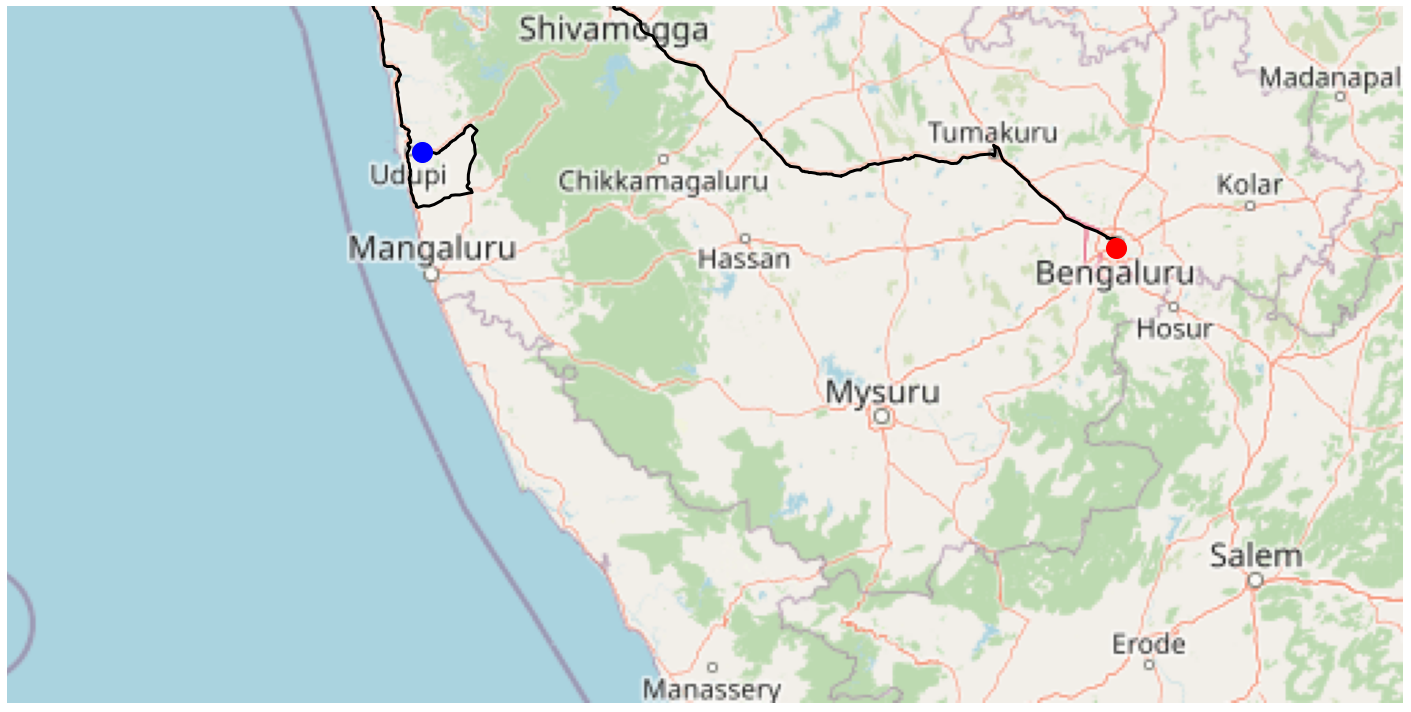

In [33]:
ax = m.show_mpl(figsize=(20, 10))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)
